In [67]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [68]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')
zip_ref = zipfile.ZipFile("/content/drive/My Drive/image-dataset/dataset-bunga.zip", 'r')
zip_ref.extractall("/tmp/dataset-bunga")
zip_ref.close()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [69]:
os.listdir('/tmp/dataset-bunga/dataset-bunga')

['17FlowerOxfordDataset']

In [70]:
base_dir = '/tmp/dataset-bunga/dataset-bunga/17FlowerOxfordDataset'

In [71]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    fill_mode = 'nearest',
                    validation_split = 0.2)

val_generator = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    fill_mode = 'nearest',
                    validation_split = 0.2)

In [72]:
train_generator = train_generator.flow_from_directory(
        base_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='categorical',
        subset = 'training')

validation_generator = val_generator.flow_from_directory(
        base_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='categorical',
        subset = 'validation')

Found 1088 images belonging to 15 classes.
Found 272 images belonging to 15 classes.


In [73]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(15, activation='softmax')
])

In [74]:
int_lr = 1e-4

model.compile(loss='categorical_crossentropy',
              optimizer = tf.optimizers.Adam(learning_rate=int_lr),
              metrics=['accuracy'])

In [75]:
ACC_THRESHOLD = 0.80

# Stop training saat accuracy mencapai 90%

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('accuracy') > ACC_THRESHOLD and logs.get('val_accuracy') > ACC_THRESHOLD):
			print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACC_THRESHOLD*100))
			self.model.stop_training = True

callback = myCallback()

In [76]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=25,
    verbose=2,
    callbacks=[callback]
)

Epoch 1/30
272/272 - 106s - loss: 2.2787 - accuracy: 0.2472 - val_loss: 2.1671 - val_accuracy: 0.3700 - 106s/epoch - 391ms/step
Epoch 2/30
272/272 - 100s - loss: 1.6551 - accuracy: 0.4200 - val_loss: 1.6413 - val_accuracy: 0.4700 - 100s/epoch - 369ms/step
Epoch 3/30
272/272 - 101s - loss: 1.3292 - accuracy: 0.5524 - val_loss: 1.4646 - val_accuracy: 0.4700 - 101s/epoch - 371ms/step
Epoch 4/30
272/272 - 98s - loss: 1.1258 - accuracy: 0.6158 - val_loss: 1.5269 - val_accuracy: 0.5100 - 98s/epoch - 361ms/step
Epoch 5/30
272/272 - 104s - loss: 1.0313 - accuracy: 0.6296 - val_loss: 1.7089 - val_accuracy: 0.5000 - 104s/epoch - 384ms/step
Epoch 6/30
272/272 - 99s - loss: 0.8990 - accuracy: 0.6958 - val_loss: 1.4708 - val_accuracy: 0.5500 - 99s/epoch - 362ms/step
Epoch 7/30
272/272 - 102s - loss: 0.8138 - accuracy: 0.7132 - val_loss: 1.0760 - val_accuracy: 0.7200 - 102s/epoch - 374ms/step
Epoch 8/30
272/272 - 100s - loss: 0.7472 - accuracy: 0.7381 - val_loss: 1.2628 - val_accuracy: 0.6500 - 100s

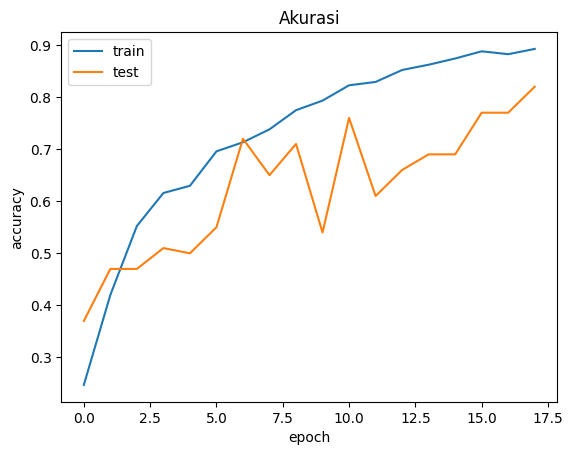

In [77]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

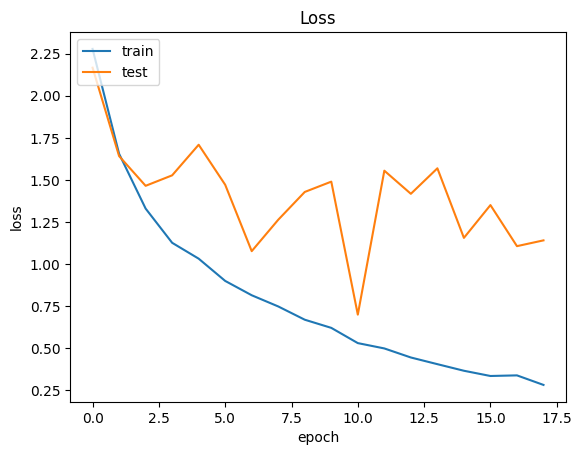

In [78]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [79]:
import pathlib

# Menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# Convert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

27281520